<div style="background-color: #8e7cc3; padding: 7px; text-align: center;">
    <h2>Projeto Machine Learning I | Problema de Classificação com KNN e Random Forest</h2>
</div>

# Grupo:
- Matheus Lopes
- Otávio Santos
- Tainah Guerra

## Descrição

**Objetivo:**

**Dados:**

| Atributo                    | Descrição                                      | 
|-----------------------------|------------------------------------------------|
| Age                         | Idade do paciente (anos) |
| Sex                         | Sexo do paciente (M: Masculino, F: Feminino)                               |
| ChestPainType               | Tipo de dor no peito (TA: Angina Típica, ATA: Angina Atípica, NAP: Dor Não-Anginosa, ASY: Assintomático) |
| RestingBP                   | Pressão arterial em repouso (mm Hg) | 
| Cholesterol                 | Colesterol sérico (mm/dl) | 
| FastingBS                   | Açúcar no sangue em jejum (1: se FastingBS > 120 mg/dl, 0: caso contrário) | 
| RestingECG                  | Resultados do eletrocardiograma em repouso (Normal: Normal, ST: anormalidade de onda ST-T, LVH: mostrando hipertrofia ventricular esquerda provável ou definitiva) |
| MaxHR                       | Frequência cardíaca máxima alcançada (60-202) | 
| ExerciseAngina              | Angina induzida por exercício (Y: Sim, N: Não) | 
| Oldpeak                     | Valor do Oldpeak = ST |                         
| ST_Slope                    | Inclinação do segmento ST no pico do exercício (Up: inclinação ascendente, Flat: plana, Down: inclinação descendente)| 
| HeartDisease                | Classe de saída (1: Doença Cardíaca, 0: Normal) | 


## Importando Bibliotecas

In [10]:
# Manipulação dos dados

import pandas as pd
import numpy as np

# DataViz

import seaborn as sns
import matplotlib.pyplot as plt

# Split dos dados

from sklearn.model_selection import train_test_split

# Transformação

from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Métricas

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


# Modelagem

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Análise Exploratória dos Dados

In [6]:
# Carregando dados

data = pd.read_csv('data/heart.csv')

In [50]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [34]:
# Checando valores duplicados

data.duplicated().sum()

0

In [37]:
# Chegando valores nulos

data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [52]:
# Distribuição dos valores numéricos

np.round(data[['Age','RestingBP','Cholesterol','FastingBS','MaxHR','Oldpeak']].describe(),1)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.0,918.0,918.0,918.0,918.0,918.0
mean,53.5,132.4,198.8,0.2,136.8,0.9
std,9.4,18.5,109.4,0.4,25.5,1.1
min,28.0,0.0,0.0,0.0,60.0,-2.6
25%,47.0,120.0,173.2,0.0,120.0,0.0
50%,54.0,130.0,223.0,0.0,138.0,0.6
75%,60.0,140.0,267.0,0.0,156.0,1.5
max,77.0,200.0,603.0,1.0,202.0,6.2


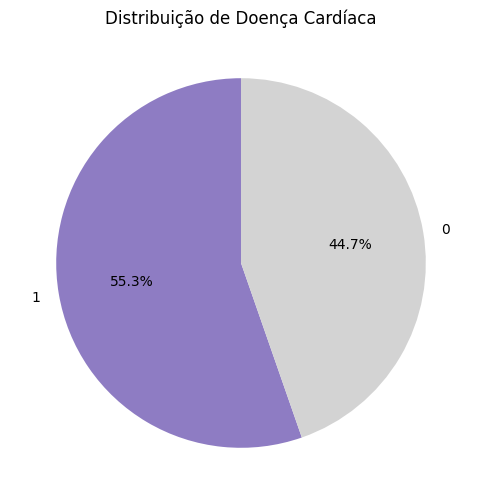

In [49]:
# Distribuição do atributo Doença Cardíaca (Target)

plt.figure(figsize=(6, 6))  
plt.pie(data['HeartDisease'].value_counts(), labels=data['HeartDisease'].value_counts().index, autopct='%1.1f%%',  startangle=90, colors=['#8e7cc3', 'lightgray'])
plt.title('Distribuição de Doença Cardíaca')
plt.show()

## Pré-processamento

## Modelo KNN

## Modelo Random Forest

## Conclusão

(onde vai fazer a comparação dos modelos)